In [2]:
import sys
sys.path.append("..")
import os
import cv2
import numpy as np
import tensorflow
import keras
import keras, keras.layers as L
sys.path.append("..")

tf.estimator package not installed.
tf.estimator package not installed.


Using TensorFlow backend.


In [31]:
#Load images
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(cv2.imread(f))
            labels.append(int(d))
    return images, labels
ROOT_PATH = ""
train_data_directory = os.path.join(ROOT_PATH, "Training")
test_data_directory = os.path.join(ROOT_PATH, "Testing")


x_train, y_train = load_data(train_data_directory)
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test, y_test = load_data(test_data_directory)
x_test = np.array(x_test)
y_test = np.array(y_test)
#Preprocess
x_test = [cv2.resize(image, (36, 36)) for image in x_test]
x_train = [cv2.resize(image, (36, 36)) for image in x_train]
x_test = np.array(x_test)
x_train = np.array(x_train)
x_train = x_train.astype('float32') / 255.0 
x_test = x_test.astype('float32') / 255.0 
data=x_train

IMG_SHAPE = x_train.shape[1:]
y_train = np.reshape(y_train,[y_train.shape[0],1])
y_test = np.reshape(y_test,[y_test.shape[0],1])

In [32]:
import tensorflow as tf
from keras_utils import reset_tf_session
s = reset_tf_session()

import keras
from keras.models import Sequential
from keras import layers as L

In [33]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(3,kernel_size=3,activation=None))



In [34]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

# <build discriminator body>
discriminator.add(L.Conv2D(32, kernel_size=3, activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))
discriminator.add(L.Conv2D(64, kernel_size=3, activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))
discriminator.add(L.Conv2D(128, kernel_size=3, activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))

discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))

In [35]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data)

generated_data = generator(noise) # <gen(noise)>

logp_gen = discriminator(generated_data)

In [36]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
#d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
disc_optimizer =  tf.train.AdamOptimizer(1e-4).minimize(d_loss,var_list=discriminator.trainable_weights)

In [37]:
########################
###generator training###
########################

g_loss = -tf.reduce_mean(logp_gen[:,1]) # <generator loss>

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

s.run(tf.global_variables_initializer())

In [38]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()


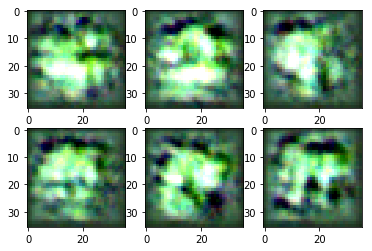

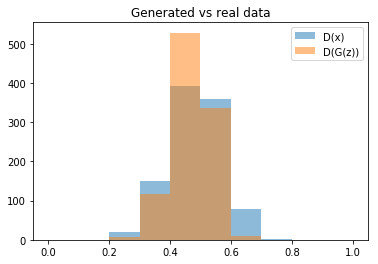

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

for epoch in range(15000):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
        s.run(gen_optimizer,feed_dict)
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)